# Enhancing the Statistical Rigor of the TN Eviction Data
## - Motivation:
-During the Exploratory Analysis it became clear that at the state and county level there are some interesting relationships between some **key metrics: **
   - **poverty-rates**, 
   - **eviction-filing-rates**,
   - **eviction-rates** themselves and 
   - **racial-distributions**. 


However, **a significant number of counties are reporting zeros for some key metrics** 
- eviction-rates 
- and eviction-filing rates 

and these values are significant to the key measurements of correlation and distributions.



It is also the case that the **poverty rates are reported annually, but only seem to be measured periodically** (about every 5 years). *We may need to find a better proxy for anual poverty values.*
- this means that instead of having about 16 data measurements per county, I really only have 4 for these variables

In [3]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf # cufflinks binds plotly to pandas dataframes in IPython notebook.
import plotly.graph_objs as go
from plotly import tools

In [4]:
sns.set(style='darkgrid')

## Read in County Level Data

In [5]:
counties_evicts_df = pd.read_csv('data/counties.csv')
counties_evicts_df.head(3)

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
0,47001,2000,Anderson County,Tennessee,71330.0,13.14,27.49,450.0,35483.0,87500.0,...,1.14,0.07,8189.0,125.0,118.0,1.44,1.53,0,0,1
1,47003,2000,Bedford County,Tennessee,37586.0,13.14,26.46,488.0,36729.0,79000.0,...,0.77,0.05,3679.0,104.0,98.0,2.66,2.83,0,0,0
2,47005,2000,Benton County,Tennessee,16537.0,15.63,19.47,367.0,28679.0,67000.0,...,0.62,0.03,1336.0,17.0,17.0,1.27,1.27,0,0,0


## Pivot County Level Data for Time Series Plotting

In [6]:
pvt_cnty_pvty_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', 
                                           values = 'poverty-rate')

pvt_cnty_evic_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'eviction-rate')

pvt_cnty_filing_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'eviction-filing-rate')

In [7]:
pvt_cnty_house_income = counties_evicts_df.pivot(index = 'year', columns = 'name', values = 'median-household-income')

## Visualize Opaquely Periodic Poverty Rates

In [8]:
layout = go.Layout(
    autosize = False,
    #rangeslider = True,
    width = 400, 
    height = 200)

pvt_cnty_pvty_rates.iplot(filename='pivoted-tn-county-poverty-timeseries', sharing = 'public',
                       #layout = layout,
                       width = 1, dash = 'line', mode = 'lines',
                      title = 'TN County Poverty Rate, 2000 - 2016', yTitle = 'Poverty %', xTitle = 'Year'
                      #rangeslider = True, 
                       )

## Visualize Distribution of Counties Reporting 0 for eviction-filing rates and for eviction-rates

Text(0.5,1,'Tn Counties, Time Series of Eviction-Rate Swarmplots, Color Coded by Percent White')

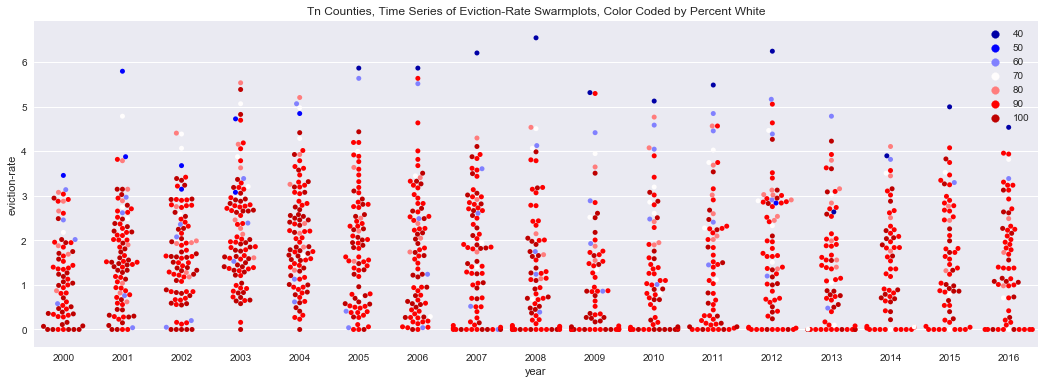

In [10]:
plt.figure(figsize=(18,6))
ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-rate'], 
                   hue = [round(val/10)*10 for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )
plt.title('Tn Counties, Time Series of Eviction-Rate Swarmplots, Color Coded by Percent White')



Text(0.5,1,'Tn Counties, Time Series of Eviction-Rate Swarmplots Color Coded by Pct-White')

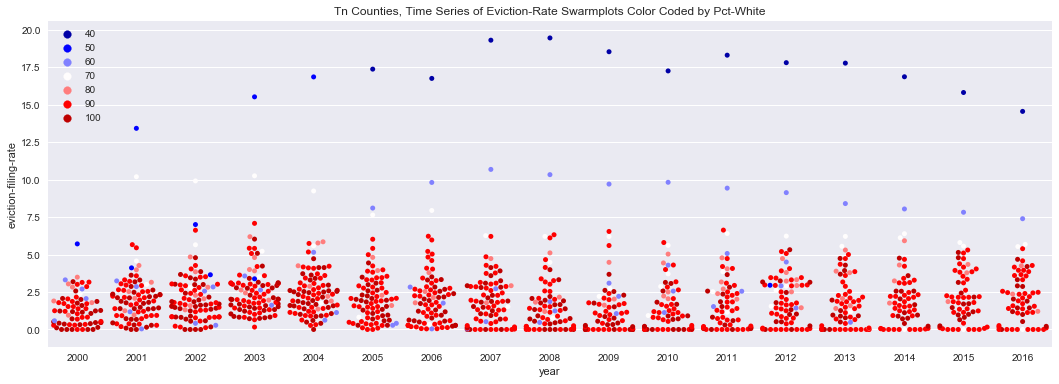

In [11]:
plt.figure(figsize=(18,6))
ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-filing-rate'], 
                   hue = [round(val/10)*10 for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )
plt.title('Tn Counties, Time Series of Eviction-Rate Swarmplots Color Coded by Pct-White')


## Are there other metrics that report suspicioulsy zero data values?

In [24]:
select_vars = ['population',
       'poverty-rate', 'pct-renter-occupied', 'median-gross-rent',
       'median-household-income', 'median-property-value', 'rent-burden',
       'pct-white', 'renter-occupied-households',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate', 'low-flag', 'imputed', 'subbed']

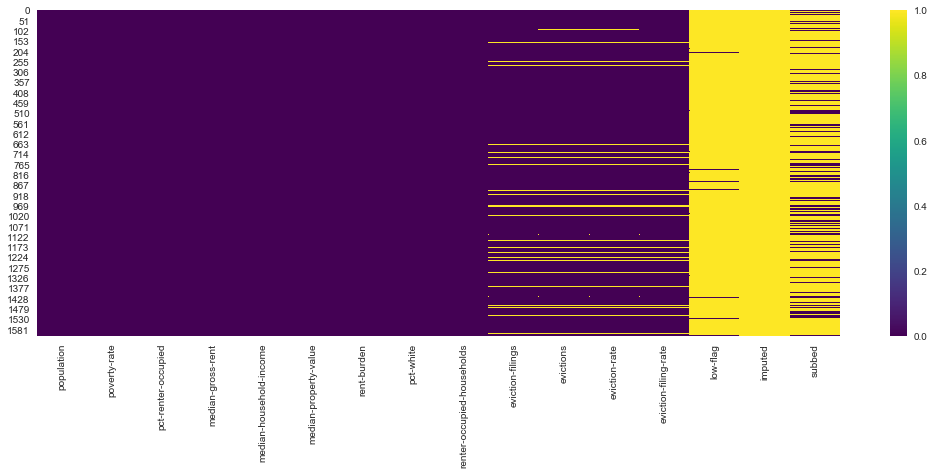

In [145]:
plt.figure(figsize=(18,6))
sns.heatmap(counties_evicts_df[select_vars] == 0, cmap = 'viridis')
plt.show()

**Note**
- Some counties seem to report filing data but not eviction data
    - **Is this because those counties indeed have no evicitions even though they did have filings?**
    - **Or is it because they don't report evictions as a matter of policy?**
    - check their methodology report to see if they mention anything about this.
        - if they don't, then maybe I can email them an ask about it.

**From Eviction Lab's Interactive Map**
- their interactive map makes it clear that eviction data gaps are not necessarily constant across time and county. 
How is this possible? Why does eviction data exist for some counties in some years but not in others?
- in the methodology report they confirmed that eviction data can be spotty across time, even for a given county

### Let's look at the rows that were flagged as low

In [19]:
counties_evicts_df[counties_evicts_df['low-flag'] != 0]

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
117,47045,2001,Dyer County,Tennessee,37279.0,15.93,34.34,424.0,32788.0,74900.0,...,0.65,0.02,5112.0,64.0,53.0,1.04,1.25,1,0,1
212,47045,2002,Dyer County,Tennessee,37279.0,15.93,34.34,424.0,32788.0,74900.0,...,0.65,0.02,5158.0,82.0,66.0,1.28,1.59,1,0,0
412,47065,2004,Hamilton County,Tennessee,307896.0,12.08,34.10,510.0,38930.0,94700.0,...,1.00,0.09,44960.0,2593.0,1465.0,3.26,5.77,1,0,0
451,47143,2004,Rhea County,Tennessee,28400.0,14.69,24.50,384.0,30418.0,76700.0,...,0.95,0.05,3069.0,74.0,60.0,1.96,2.41,1,0,0
592,47045,2006,Dyer County,Tennessee,37698.0,18.79,35.25,549.0,36121.0,90100.0,...,1.02,0.00,5343.0,95.0,93.0,1.74,1.78,1,0,0
697,47065,2007,Hamilton County,Tennessee,330941.0,9.95,33.04,652.0,45557.0,142500.0,...,1.10,0.07,46857.0,2931.0,911.0,1.94,6.26,1,0,0
756,47183,2007,Weakley County,Tennessee,33389.0,14.31,32.28,494.0,33506.0,80000.0,...,0.92,0.09,4619.0,61.0,58.0,1.26,1.32,1,0,1
792,47065,2008,Hamilton County,Tennessee,330941.0,9.95,33.04,652.0,45557.0,142500.0,...,1.10,0.07,47489.0,2126.0,1933.0,4.07,4.48,1,0,0
851,47183,2008,Weakley County,Tennessee,33389.0,14.31,32.28,494.0,33506.0,80000.0,...,0.92,0.09,4676.0,71.0,59.0,1.26,1.52,1,0,1
869,47029,2009,Cocke County,Tennessee,35406.0,17.17,26.05,477.0,30027.0,92500.0,...,1.38,0.16,4052.0,60.0,60.0,1.48,1.48,1,0,1


In [155]:
list(enumerate(set(counties_evicts_df[counties_evicts_df['low-flag'] != 0].name)))

[(0, 'Hamilton County'),
 (1, 'Knox County'),
 (2, 'Wilson County'),
 (3, 'Rhea County'),
 (4, 'Henderson County'),
 (5, 'Sumner County'),
 (6, 'Sullivan County'),
 (7, 'Cocke County'),
 (8, 'Dyer County'),
 (9, 'Dickson County'),
 (10, 'White County'),
 (11, 'Franklin County'),
 (12, 'Putnam County'),
 (13, 'Carter County'),
 (14, 'Weakley County'),
 (15, 'Anderson County'),
 (16, 'Hawkins County')]

In [158]:
len(set(counties_evicts_df[counties_evicts_df['low-flag'] != 0].name))/len(set(counties_evicts_df.name))

0.17894736842105263

⚠️ I should have more than just 28 rows marked as low. I seem to recall that if the State is marked as low, which TN is, then at least 25% of it's counties have to be marked as low. But I only have 17 counties represented here (about 18%). 

## On the website's map Hickman County is flagged as having a low eviction-rate (but not a low eviction count) from 2005 - 2016. 
- But I don't see that reflected in the data frame
    - Hickman County is flagged as "subbed" from 2005 - 2016
        - Does this mean that they replaced the low county-reported values with their own imputed values?
        - **What is the technical meaning of "subbed?"**

From the Data Dictionary:
- imputed
    - Boolean variable indicating whether eviction numbers and renter-occupied-households were imputed
    - 0: false, 1: true
- subbed
    - Boolean variable indicating whether eviction numbers and renter-occupied-households were pulled from another source other than Eviction Lab sources (*probably from lexis nexis etc...)*
    - 0: false, 1: true
    
**Why doesn't 'low-flag' appear in the dictionary?**

### Why is Hickman County flagged as low on the map but not in the csv?

In [39]:
counties_evicts_df[counties_evicts_df.name == 'Hickman County'][['GEOID','year', 'name','renter-occupied-households', 'eviction-filings', 'evictions', 'eviction-rate', 'eviction-filing-rate', 'low-flag', 'imputed', 'subbed']]

,GEOID,year,name,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
40,47081,2000,Hickman County,1602.0,11.0,10.0,0.62,0.69,0,0,0
135,47081,2001,Hickman County,1647.0,27.0,24.0,1.46,1.64,0,0,0
230,47081,2002,Hickman County,1692.0,25.0,21.0,1.24,1.48,0,0,0
325,47081,2003,Hickman County,1737.0,32.0,32.0,1.84,1.84,0,0,0
420,47081,2004,Hickman County,1782.0,19.0,17.0,0.95,1.07,0,0,0
515,47081,2005,Hickman County,1827.0,2.0,2.0,0.11,0.11,0,0,1
610,47081,2006,Hickman County,1872.0,5.0,5.0,0.27,0.27,0,0,1
705,47081,2007,Hickman County,1917.0,1.0,1.0,0.05,0.05,0,0,1
800,47081,2008,Hickman County,1962.0,1.0,1.0,0.05,0.05,0,0,1
895,47081,2009,Hickman County,2007.0,0.0,0.0,0.00,0.00,0,0,1


### Let's look at EL's non-imputed data to see if it persists this oddity.

In [ ]:
non_imputed_counties_evicts_df = pd.read_csv('data/non-imputed-counties.csv')

In [37]:
non_imputed_counties_evicts_df[non_imputed_counties_evicts_df.GEOID == 47081]

,GEOID,year,renter-occupied-households,eviction-filings,eviction-filings-imp,eviction-filings-non-imp,evictions,evictions-imp,evictions-non-imp,eviction-rate,eviction-filing-rate,imputed,subbed,low-flag
41956,47081,2000,1602,11.0,2.0,9.0,10.0,2.0,8.0,0.62,0.69,0,0,0
41957,47081,2001,1647,27.0,5.0,22.0,24.0,5.0,19.0,1.46,1.64,0,0,0
41958,47081,2002,1692,25.0,3.0,22.0,21.0,2.0,19.0,1.24,1.48,0,0,0
41959,47081,2003,1737,32.0,5.0,27.0,32.0,5.0,27.0,1.84,1.84,0,0,0
41960,47081,2004,1782,19.0,2.0,17.0,17.0,1.0,16.0,0.95,1.07,0,0,0
41961,47081,2005,1827,2.0,0.0,2.0,2.0,0.0,2.0,0.11,0.11,0,0,1
41962,47081,2006,1872,5.0,0.0,5.0,5.0,0.0,5.0,0.27,0.27,0,0,1
41963,47081,2007,1917,1.0,0.0,1.0,1.0,0.0,1.0,0.05,0.05,0,0,1
41964,47081,2008,1962,1.0,0.0,1.0,1.0,0.0,1.0,0.05,0.05,0,0,1
41965,47081,2009,2007,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0,0,1


## the non-imputed csv corroborates what their map reports. 
- i.e. Hickman County is flagged as low in both the map and the non-imputed csv
- ⚠️ but not in the counties.csv that they published

**That's Alarming ⚠️ **
- it looks like maybe the order of the column names for the flags got mixed up.
- it looks like the non-imputed data values for 'low-flag' were labeled as 'subbed' in the published data.
    - in fact it looks like maybe the column tags are shifted to the right by one. i.e.:
        - imputed -> subbed
        - subbed -> low-flag
        - low-flag -> imputed

Well, let's test this concern on other counties
## Are the flag columns mislabeled in EL's data?

#### here is a "toy case" where we validate the method of comparing columns of equal lenght in two different data frames

In [118]:
a = [[10, 10, 4.2], [15, 15, 0.03], [10, 10, 0]]
df = pd.DataFrame(a, columns=['one', 'two', 'three'])
df1 = pd.DataFrame(a, columns = ['uno', 'dos', 'tres'])
df1.index = [3,4,5]

In [119]:
df

,one,two,three
0,10,10,4.20
1,15,15,0.03
2,10,10,0.00


In [121]:
df1

,uno,dos,tres
3,10,10,4.20
4,15,15,0.03
5,10,10,0.00


In [129]:
df.one.reset_index(drop = True).equals(df1.uno.reset_index(drop = True))
# it's important to reset the index of the selected columns, otherwise the .equals() method will return false if the indices are not equal as well

True

*the notation below is more human-readable and still functional*

In [130]:
counties_evicts_df[
    counties_evicts_df.GEOID == 47081][
    'subbed'].reset_index(drop = True).equals(
    non_imputed_counties_evicts_df[
        non_imputed_counties_evicts_df.GEOID == 47081][
        'low-flag'].reset_index(drop = True))

True

test the loop out on the toy case

In [117]:
for val in list(set(df.three)):
    print(df[
        df.three == val
    ]['one'].reset_index(drop = True).equals(
    df1[
        df1.tres == val
    ]['uno'].reset_index(drop = True)))

True
True
True


### assert that flag columns are possitionally equal

In [294]:
# for each geoid:
for geoid in list(set(counties_evicts_df.GEOID)):
    # check to see if the columns are positionally equal instead of nominally equal
    
    # assert the leftmost flag colums are equal
    assert counties_evicts_df[
        counties_evicts_df.GEOID == geoid][
        'low-flag'].reset_index(drop = True).equals(
        non_imputed_counties_evicts_df[
            non_imputed_counties_evicts_df.GEOID == geoid][
            'imputed'].reset_index(drop = True))
    
    # assert the middle flag colums are equal
    assert counties_evicts_df['imputed'][counties_evicts_df.GEOID == geoid].reset_index(drop = True).equals(
        non_imputed_counties_evicts_df['subbed'][non_imputed_counties_evicts_df.GEOID == geoid].reset_index(drop = True)
    )
    
    # assert the rightmost flag columns are equal
    assert counties_evicts_df['subbed'][counties_evicts_df.GEOID == geoid].reset_index(drop = True).equals(
        non_imputed_counties_evicts_df['low-flag'][non_imputed_counties_evicts_df.GEOID == geoid].reset_index(drop = True)
    )

# 🤯 Flag columns are positionally but not nominally equal
Ok, so, either:
1. EL mislabeled their data or
2. The rows that were marked as low-flag in the non-imputed dataset are the ones that were substituted for some other value in the published data set
    - **but, if this were the case, then why would they flag that row as low on the map, but not on the published data?**
        - also, if the data is subbed, why isn't it labeled as such in the non-imputed data set. What was it substituted with?

### There seem to be other inconsistencies as well:
- the nimp data set uses the sum of imp and nimp to calculate evictions, and filings counts
    - that sum is divided by renter-occupied-households to calculate the rates
        - **But nothing is flagged as low, imputed, or substituted on those rows with non-zero imputed values.** (At least for Hickman County).
- when values are flagged as low in the nimp data, they are not flagged as subbed, 
    - but then for some reason they are marked as subbed, but not as low in the imp data.


write out this concerning subset for EL's reference

In [143]:
#non_imputed_counties_evicts_df[non_imputed_counties_evicts_df.GEOID == 47081].to_csv('data/nimp-hickman-county-tn.csv')
#counties_evicts_df[counties_evicts_df.name == 'Hickman County'][['GEOID','year','renter-occupied-households', 'eviction-filings', 'evictions', 'eviction-rate', 'eviction-filing-rate', 'low-flag', 'imputed', 'subbed']].to_csv('data/hickman-county-tn.csv')

Confirm the above inconsistencies for all counties.

**confirm each eviction, filing count is the sum of imputed and non-imputed counts**

In [235]:
for i in non_imputed_counties_evicts_df.dropna().index:
    # confirm eviction-filings is the sum of imp and nimp counts
    if non_imputed_counties_evicts_df['eviction-filings'][i] != non_imputed_counties_evicts_df['eviction-filings-non-imp'][i] + non_imputed_counties_evicts_df['eviction-filings-imp'][i]:
        print(non_imputed_counties_evicts_df[i])
    # confirm evictions is the sum of imp and nimp counts
    if non_imputed_counties_evicts_df['evictions'][i] != non_imputed_counties_evicts_df['evictions-imp'][i] + non_imputed_counties_evicts_df['evictions-non-imp'][i]:
        print(non_imputed_counties_evicts_df[i])    

**identify those counties marked as not-imputed that nonetheless use imputed values to calculate their counts**

In [314]:
non_imputed_counties_evicts_df.columns

Index(['GEOID', 'year', 'renter-occupied-households', 'eviction-filings',
       'eviction-filings-imp', 'eviction-filings-non-imp', 'evictions',
       'evictions-imp', 'evictions-non-imp', 'eviction-rate',
       'eviction-filing-rate', 'imputed', 'subbed', 'low-flag'],
      dtype='object')

In [322]:
rows_of_interest = []

# for all rows marked as non-imputed
for i in non_imputed_counties_evicts_df[non_imputed_counties_evicts_df['imputed'] == 0].dropna().index:
    # filter down to the rows that are also in TN
    if non_imputed_counties_evicts_df.GEOID[i] in counties_evicts_df.GEOID:
        # filter down to rows with non-zero imputed data
        if non_imputed_counties_evicts_df['evictions-imp'][i] != 0 or non_imputed_counties_evicts_df['eviction-filings-imp'][i] != 0:
            # filter down to the rows that use that non-imputed data nonetheless
            if non_imputed_counties_evicts_df['eviction-filing-rate'][i] == round(100*non_imputed_counties_evicts_df['eviction-filings'][i]/non_imputed_counties_evicts_df['renter-occupied-households'][i], 2):
                rows_of_interest.append(i)
            
print(len(rows_of_interest), 'TN county rows are labeld as non-imputed but use imputed data nonetheless')
print('that is: ', round(100*len(rows_of_interest)/counties_evicts_df.shape[0], 2), '%')
\

986 TN county rows are labeld as non-imputed but use imputed data nonetheless
that is:  61.05 %


In [303]:
'''rows_of_interest = []

for i in non_imputed_counties_evicts_df[non_imputed_counties_evicts_df['imputed'] == 0].dropna().index:
    if non_imputed_counties_evicts_df['eviction-rate'][i] != round(100*(non_imputed_counties_evicts_df['evictions'][i]/non_imputed_counties_evicts_df['renter-occupied-households'][i]), 2):
        if abs(non_imputed_counties_evicts_df['eviction-rate'][i] - round(100*(non_imputed_counties_evicts_df['evictions'][i]/non_imputed_counties_evicts_df['renter-occupied-households'][i]), 2)) > 0.021:
            rows_of_interest.append(i)
            print('index', i)
            print(non_imputed_counties_evicts_df['eviction-rate'][i],
                  #non_imputed_counties_evicts_df['evictions'][i],
                  #non_imputed_counties_evicts_df['renter-occupied-households'][i]
                 ' ')
            print('calculated: ', round(100*(non_imputed_counties_evicts_df['evictions'][i]/non_imputed_counties_evicts_df['renter-occupied-households'][i]), 2))
            #print(type(non_imputed_counties_evicts_df['eviction-rate'][i]))
            #print(type(round(100*non_imputed_counties_evicts_df['evictions'][i]/non_imputed_counties_evicts_df['renter-occupied-households'][i], 2)))
            print("")'''

'rows_of_interest = []\n\nfor i in non_imputed_counties_evicts_df[non_imputed_counties_evicts_df[\'imputed\'] == 0].dropna().index:\n    if non_imputed_counties_evicts_df[\'eviction-rate\'][i] != round(100*(non_imputed_counties_evicts_df[\'evictions\'][i]/non_imputed_counties_evicts_df[\'renter-occupied-households\'][i]), 2):\n        if abs(non_imputed_counties_evicts_df[\'eviction-rate\'][i] - round(100*(non_imputed_counties_evicts_df[\'evictions\'][i]/non_imputed_counties_evicts_df[\'renter-occupied-households\'][i]), 2)) > 0.021:\n            rows_of_interest.append(i)\n            print(\'index\', i)\n            print(non_imputed_counties_evicts_df[\'eviction-rate\'][i],\n                  #non_imputed_counties_evicts_df[\'evictions\'][i],\n                  #non_imputed_counties_evicts_df[\'renter-occupied-households\'][i]\n                 \' \')\n            print(\'calculated: \', round(100*(non_imputed_counties_evicts_df[\'evictions\'][i]/non_imputed_counties_evicts_df[\'ren

In [311]:
#non_imputed_counties_evicts_df[[i in rows_of_interest for i in non_imputed_counties_evicts_df.index]]

In [312]:
nimp_flags = [non_imputed_counties_evicts_df.imputed == 0]
imp_vars = [col for col in non_imputed_counties_evicts_df.columns if '-imp' in col and 'non' not in col]

# Visualize distribution of NaNs

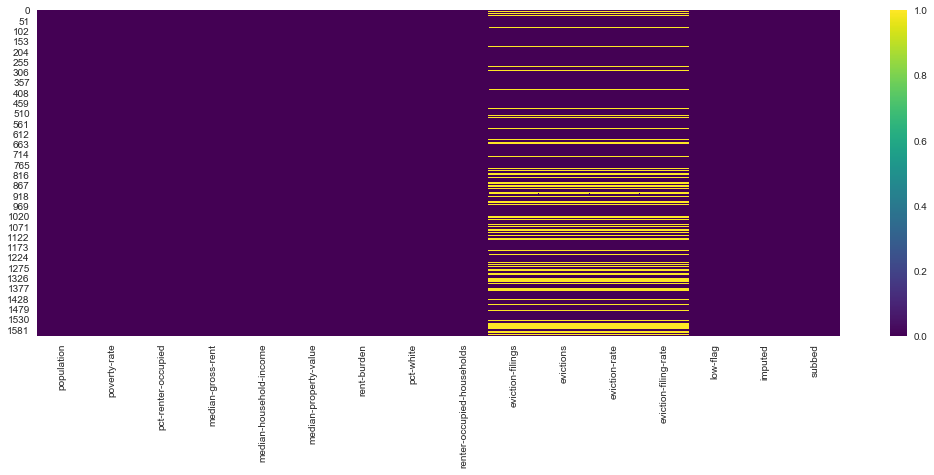

In [28]:
plt.figure(figsize=(18,6))
sns.heatmap(counties_evicts_df[select_vars].isna(), cmap = 'viridis')
plt.show()

### Confirm there is a one-to-one correspondance between NaNs in the eviction variables
i.e. if there is an NaN in any of the eviction columns, then all the other eviction variables in that row are also NaNs

In [22]:
# for each eviction variable (other than evictions themselves):
for var in ['eviction-filings', 'eviction-rate', 'eviction-filing-rate']:
    # Confirm that each row with an NaN eviction value also has an NaN in that other eviction variable
    assert (counties_evicts_df['evictions'].isna() != counties_evicts_df[var].isna()).sum() == 0 # the sum of eviction Nan indices that are not NaN indices in the other column is zero 

### Confirm my plotting routines are handling NaNs properly ✅ 

In [23]:
data = [
    go.Box(
        y = [0, 1, 2, 3, np.nan, 5, 8, 13, 21],
        boxpoints = 'all',
        jitter = 0.3,
        pointpos = -1.8
    )
]
py.iplot(data)

In [24]:
yi = np.array([0, 1, 2, 3, np.nan, 5, 8, 13, 21])
xi = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask = ~np.isnan(xi) & ~np.isnan(yi)

slope, intercept, r_value, p_value, std_err = stats.linregress(xi[mask], yi[mask])

line = slope*xi+intercept

data = [
    go.Scatter(
        y = [0, 1, 2, 3, np.nan, 5, 8, 13, 21],
        x = [0, 1, 2, 3, 4, 5, 6, 7, 8],
        mode = 'lines+markers'
    ),
    go.Scatter(
        x = xi,
        y = line,
        mode = 'lines',
        marker = go.Marker(color = 'red')
        )
]
py.iplot(data)

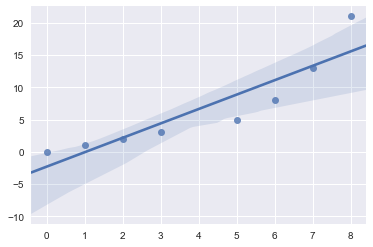

In [25]:
yi = np.array([0, 1, 2, 3, np.nan, 5, 8, 13, 21])
xi = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
sns.regplot(xi, yi)

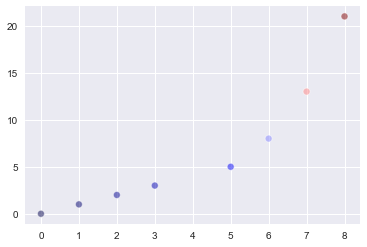

In [26]:
plt.scatter(xi, yi, edgecolors = 'white', linewidths= 1, alpha = .5, c = yi/2, cmap = 'seismic')

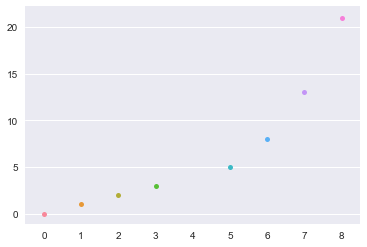

In [27]:
sns.swarmplot(x = xi, y = yi)

## Other metrics that have opaquely periodic data:
see swarmplots below

## Periodic Data Variables:
- population
- poverty-rate
- pct-renter-occupied
- median-gross-rent
- median-household-income
- median-property-values
- rent-burden
- pct-white

## Annual Data Variables:
- renter-occupied-households
- eviction-filings
- evictions
- eviction-rate
- eviction-filing-rate

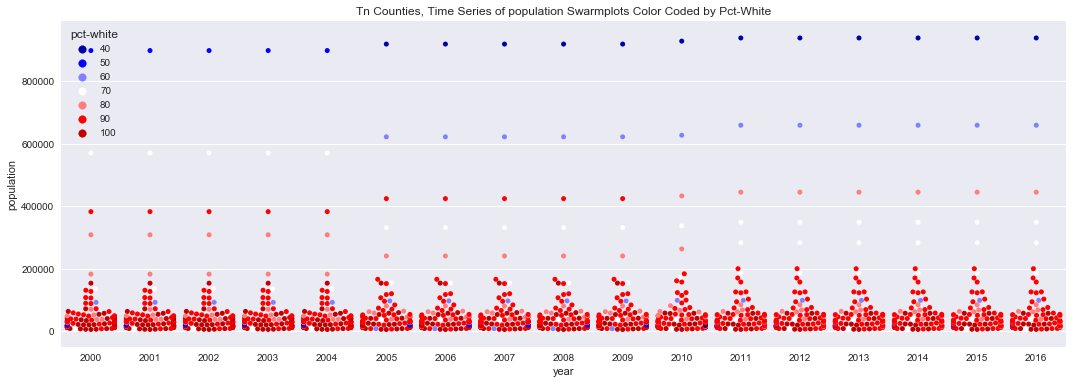

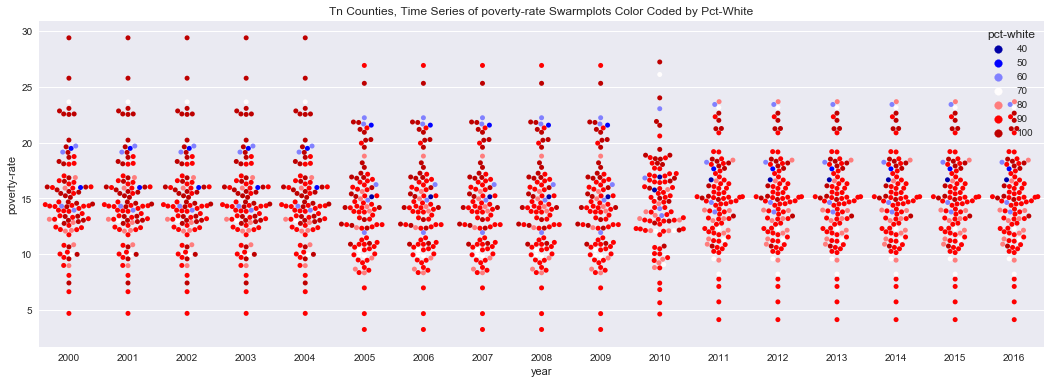

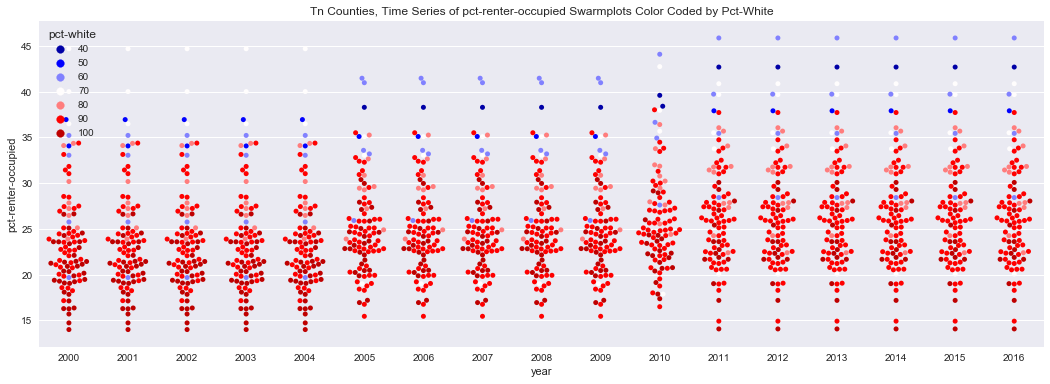

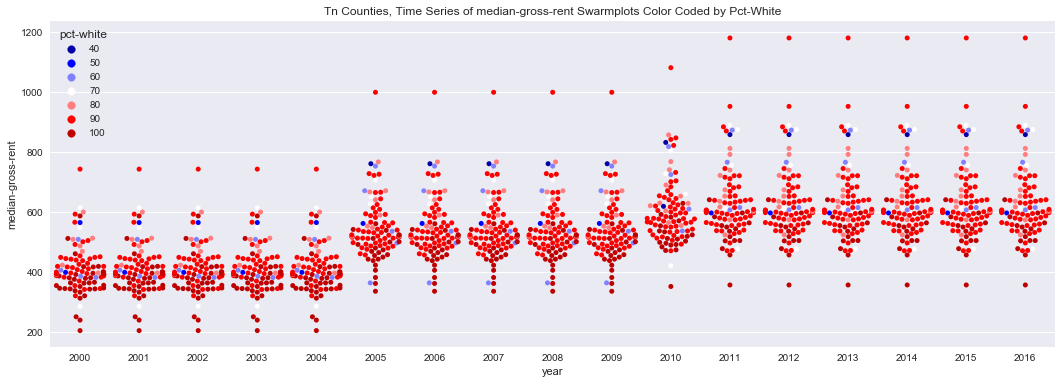

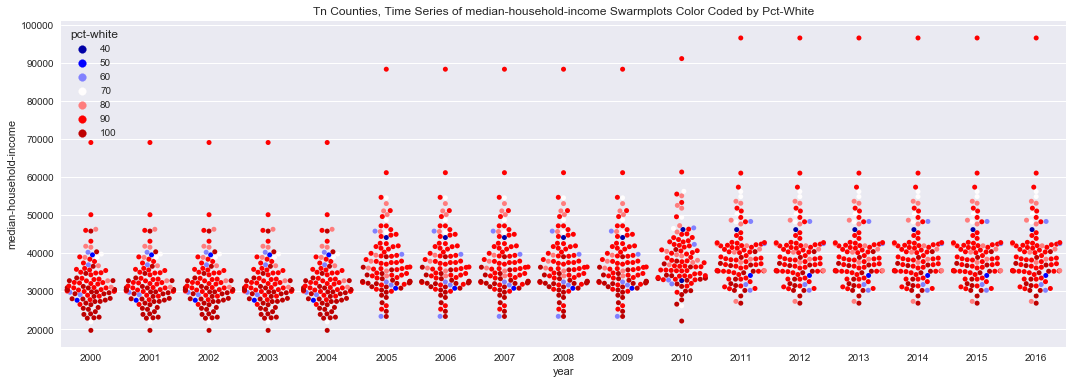

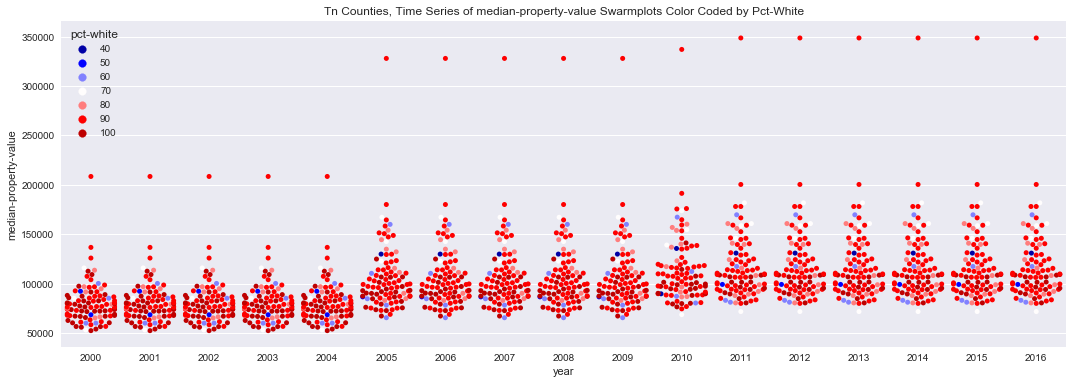

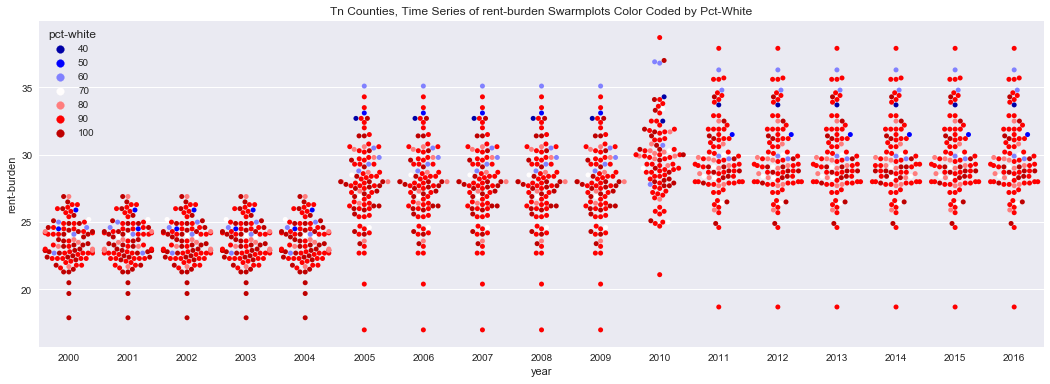

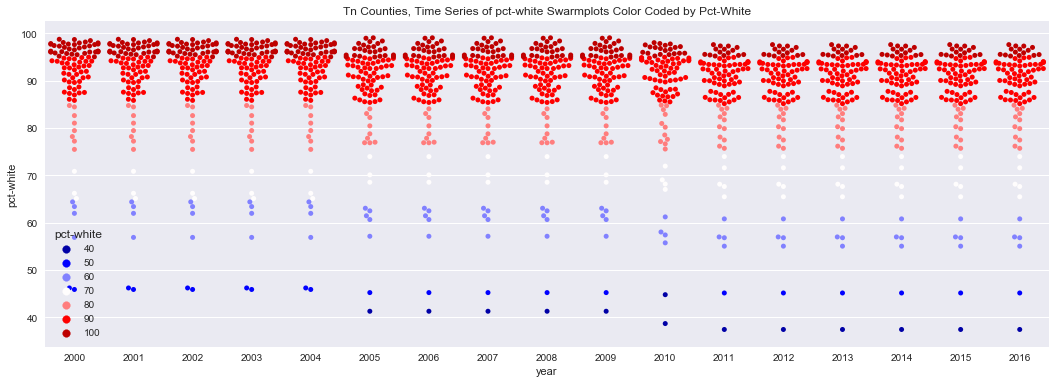

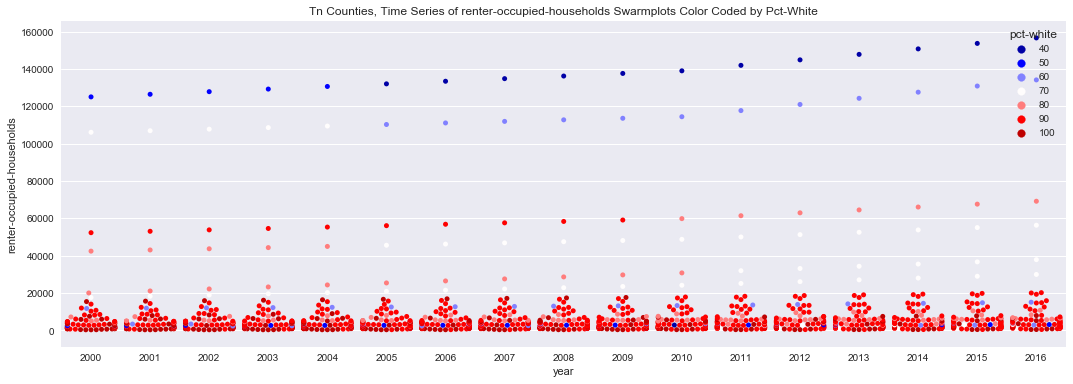

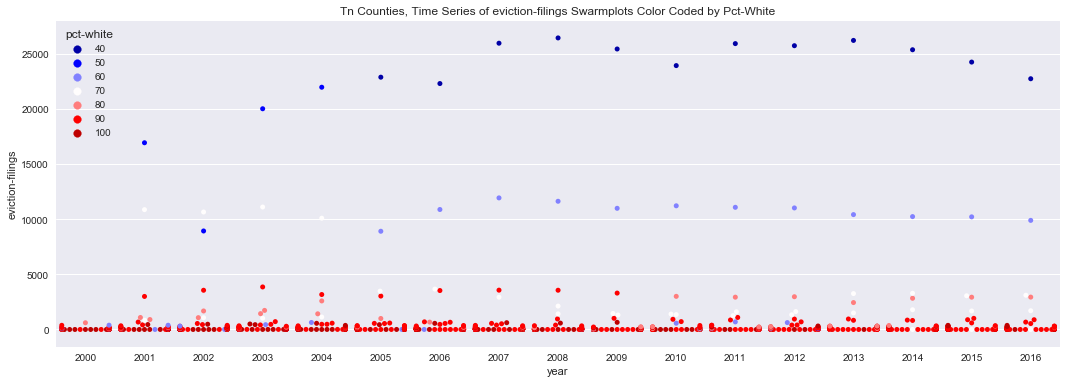

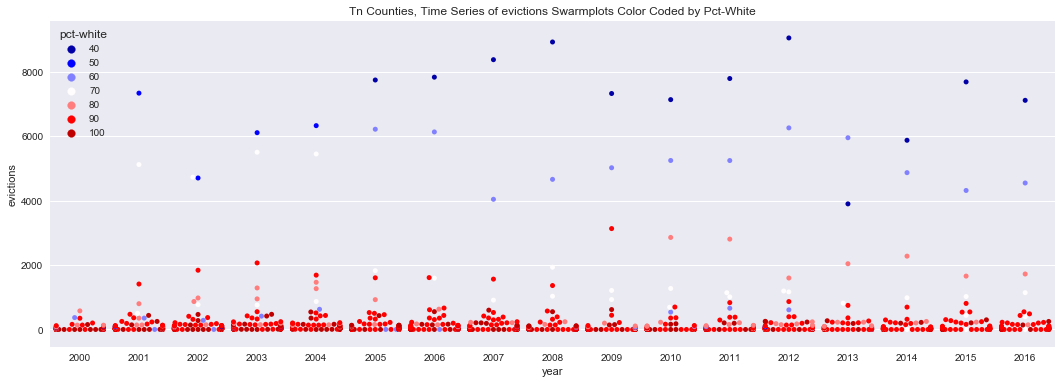

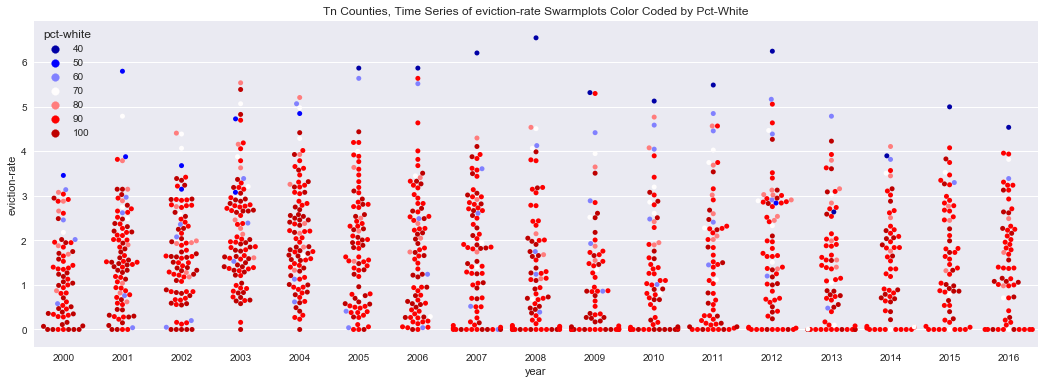

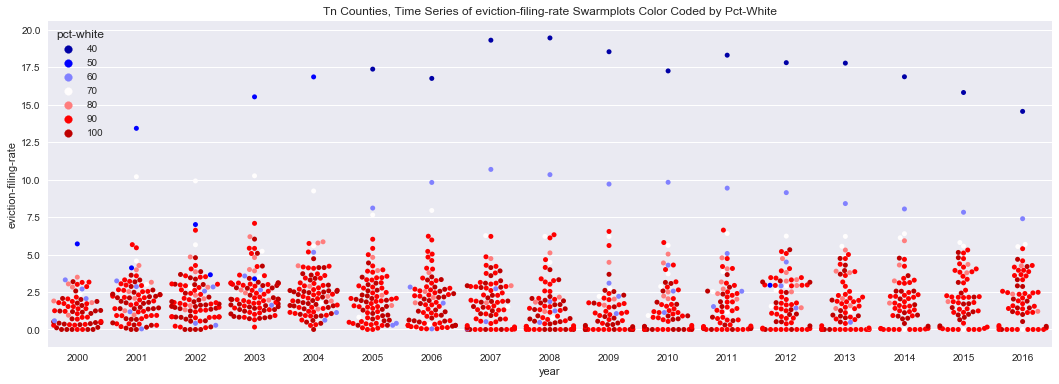

In [12]:
for var in ['population',
       'poverty-rate', 'pct-renter-occupied', 'median-gross-rent',
       'median-household-income', 'median-property-value', 'rent-burden',
       'pct-white', 'renter-occupied-households',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate']:
    plt.figure(figsize=(18,6))
    ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df[var], 
                   hue = [round(val/10)*10 for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )
    plt.title('Tn Counties, Time Series of ' + var + ' Swarmplots Color Coded by Pct-White')
    plt.legend(title = 'pct-white')
    plt.show()